<a href="https://colab.research.google.com/github/YusufGulcan/ARIMA-SARIMA/blob/main/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import stats
import math
import warnings
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from google.colab import drive
from datetime import datetime
import seaborn as sns


In [2]:
driver = drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
path = '/content/drive/My Drive/Database/BTC_price.csv'
df= pd.read_csv(path)
df.head(3)

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,1609459200000,28923.63,28961.66,28913.12,28961.66,27.457032,1609459259999,7.943820e+05,1292,16.777195,485390.826825
1,1609459260000,28961.67,29017.50,28961.01,29009.91,58.477501,1609459319999,1.695803e+06,1651,33.733818,978176.468202
2,1609459320000,29009.54,29016.71,28973.58,28989.30,42.470329,1609459379999,1.231359e+06,986,13.247444,384076.854453


In [4]:
df['Open Time']=df['Open Time'].apply(lambda x:datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))      ## The time format is unix timestamp so I need to convert it to datetime format before I can use it.
df['Close Time']=df['Close Time'].apply(lambda x:datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))   

In [5]:
df = df.set_index('Open Time')              ## in order to resample the data I make time-series column index of the data frame.

In [6]:
df.index = pd.to_datetime(df.index)          ## After making it index I convert the data type from object to datetime.

In [7]:
df['Close Time'] = pd.to_datetime(df['Close Time'])

In [8]:
df=df.resample('h').mean()                             ## Here I resample the data frame, before each row represented 1 minute. Now it is changed to hourly data.
df['50MA'] =  df.Open.rolling(window=50).mean()          ## Create a 50 period moving average

Text(0.5, 1.0, 'Bitcoin Price')

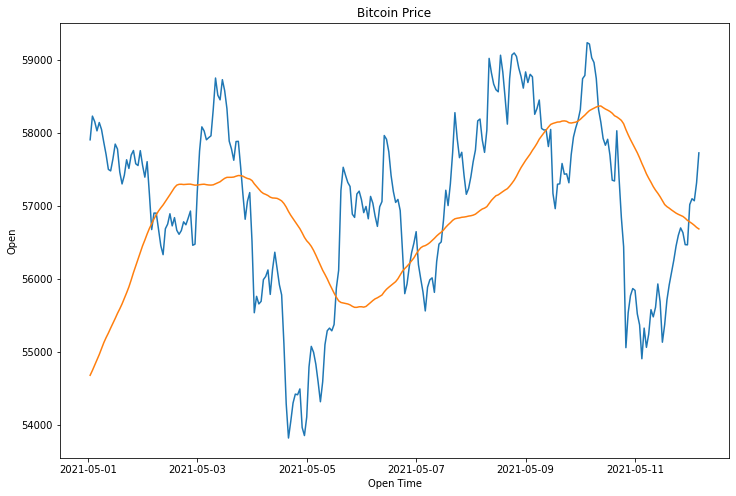

In [42]:
plt.figure(figsize=(12,8))
sns.lineplot(x= df[df.index>'2021-05-01 00:00:00'].index , y= df[df.index>'2021-05-01 00:00:00'].Open)
plt.plot(df[df.index>'2021-05-01 00:00:00'].index,df[df.index>'2021-05-01 00:00:00']['50MA'])
plt.title('Bitcoin Price')
                                    ## A little visual representation of the price

In [10]:
df = df.interpolate(method='linear')                ## There is a small number of null values, so I fill the null values with average of the preceding and the following rows. 

In [11]:
ARIMA_model=pm.auto_arima(df[df.index>'2021-05-01 00:00:00'].Open)                ## call the ARIMA model and supply the data.

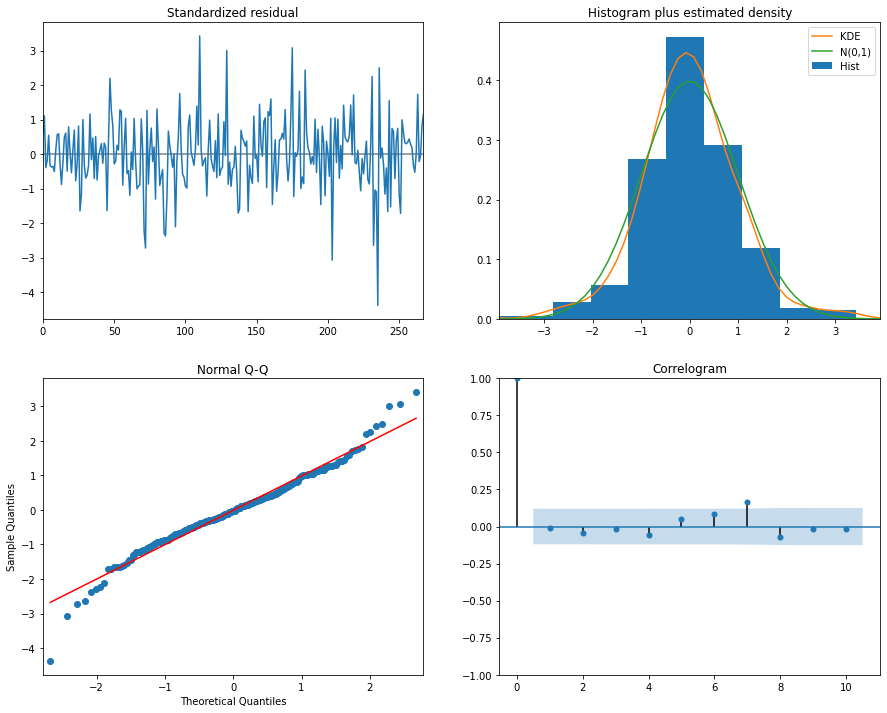

In [12]:
ARIMA_model.plot_diagnostics(figsize=(15,12))                    
plt.show()

In [13]:
df.index[-1] + pd.DateOffset(months=1)             

Timestamp('2021-06-12 04:00:00')

In [14]:
n_periods = 24
index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')                ## Create index for the following time period that I plan  to make predictions for.

In [15]:
fitted,confint=ARIMA_model.predict(n_periods = n_periods,return_conf_int=True)                        ## ARIMA model returns an array for predictions and an array for confidence interval.

In [16]:
fitted_series = pd.Series(fitted, index=index_of_fc)                                                   ## Create pandas series for predictions and confidence interval
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

Text(0.5, 1.0, 'Price Prediction/Confidence Interval')

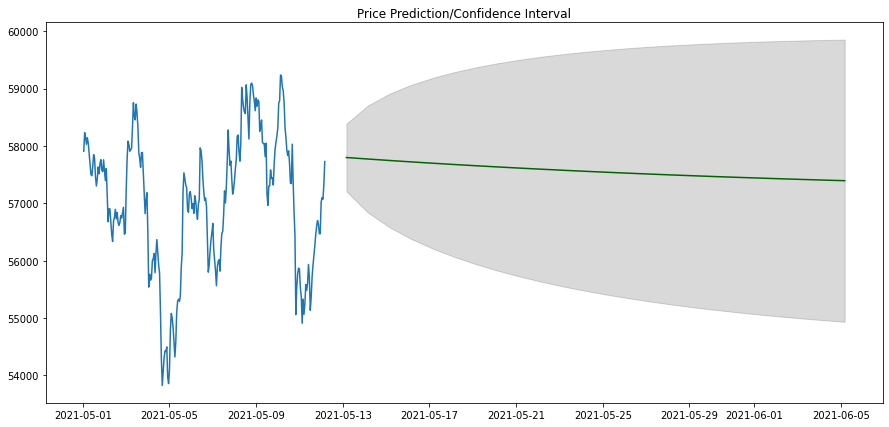

In [43]:
plt.figure(figsize=(15,7))
plt.plot(df[df.index>'2021-05-01 00:00:00'].Open, color='#1f76b4')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)
plt.title('Price Prediction/Confidence Interval')                                         ## Plot the outcomes of ARIMA model

array([57210.7398813 , 56775.73569234, 56707.58496922, 56601.82859125,
       56568.47924444, 56487.03193508, 56440.99015231, 56772.24597207,
       56842.83155308, 56857.12292421, 57044.51225201, 57409.38486693,
       57011.2145768 , 56708.87442071, 56695.0359306 , 56617.12693816,
       56584.76633757, 56511.57660798, 56455.58269528, 56760.71761445,
       56839.98817158, 56865.20825552, 57059.95914822, 57416.01657418,
       57033.13248551, 56739.33173292, 56724.93580466, 56651.89344368,
       56615.22141695, 56532.91692232])

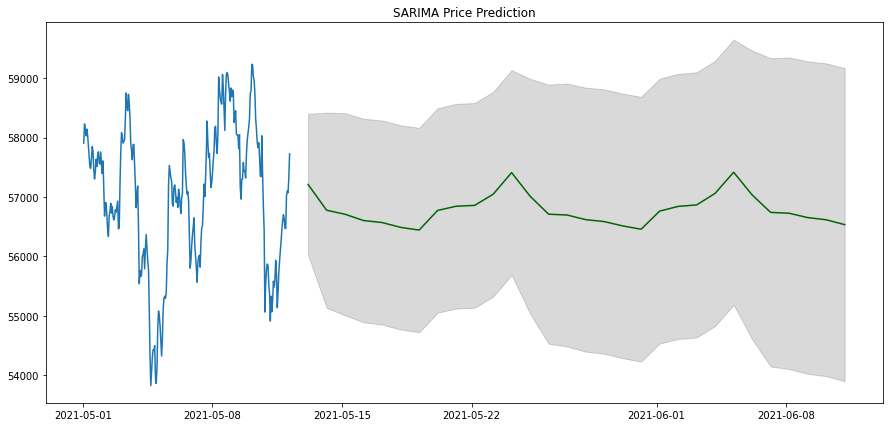

In [44]:
from pmdarima.arima import seasonality                                                                  ## The process of SARIMA is very similar like ARIMA's. 
def SARIMA(data,periodss):                                                                             ## The only difference is the seasonality hyperparameter of auto_arima function is set to True 
   Sarrima = pm.auto_arima(data, start_p=1, start_q=1,                                                 ## which forces the model take seasonality into consideration.
                         test='adf',                                                                    ## The remaining steps are the same. I wrapped the lines up with a function.
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
   index_forcst=pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = periodss, freq='D')             
   pred, confd = Sarrima.predict(return_conf_int = True,n_periods=periodss )

   prediction=pd.Series(pred,index=index_forcst)
   lower=pd.Series(confd[:,0],index=index_forcst)
   upper=pd.Series(confd[:,1],index=index_forcst)

 
   plt.figure(figsize=(15,7))
   plt.plot(df[df.index>'2021-05-01 00:00:00'].Open, color='#1f76b4')
   plt.plot(prediction, color='darkgreen')
   plt.fill_between(lower.index, 
                  lower, 
                  upper, 
                  color='k', alpha=.15)
   plt.title('SARIMA Price Prediction')
   return pred


SARIMA(df[df.index>'2021-04-01 00:00:00'].Open,30)

This is an example of ARIMA / SARIMA time-series price prediction model. 